### Accedemos al directorio de Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


# Acceso Directorio:
!ls -l "/content/drive/My Drive/Colab Notebooks/Alzheimer_Project"

### Importamos las librerías requeridas

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array


# Input data files are available in the "../input/" directory.
# For example, runniЃng this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
os.listdir("/content/drive/My Drive/Colab Notebooks/Alzheimer_Project/input/Data/Train")


# Any results you write to the current directory are saved as output.

['AD', 'CN', 'EMCI']

### Definimos los parámetros

In [5]:
data_generator = ImageDataGenerator(horizontal_flip=False,
                                   width_shift_range = 0,
                                   height_shift_range = 0,
                                   zoom_range=0,
                                   rotation_range=0,
                                   )

image_h = 240
image_w = 160
batch_size = 32
learning_rate = 0.003
epocas = 10


#Lectura de Datos de entrenamiento
train_generator = data_generator.flow_from_directory(
        "/content/drive/My Drive/Colab Notebooks/Alzheimer_Project/input/Data/Train",
        target_size=(image_h, image_w),
        batch_size=batch_size,
        class_mode='categorical')

#Lectura de Datos de test
test_data = data_generator.flow_from_directory("/content/drive/My Drive/Colab Notebooks/Alzheimer_Project/input/Data/Test",
                                              target_size=(image_h, image_w),
                                              batch_size = batch_size,
                                              class_mode= 'categorical')

num_classes = len(train_generator.class_indices)

Found 15000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


### Definimos la estructura del modelo

In [17]:
model = Sequential()

model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet')) #'imagenet' --> Pesos por defecto en resnet50 (creo)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.layers[0].trainable = False

94658560/94653016 [==============================] - 2s 0us/step


### Compilamos el modelo 

In [0]:
model.compile(optimizer=optimizers.Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

### Entrenamos el modelo y lo guardamos en un directorio 

In [19]:
#Necesitamos saber la cantidad de datos de entrenamiento y testeo para así calcular los pasos por época
count = sum([len(files) for r, d, files in os.walk("/content/drive/My Drive/Colab Notebooks/Alzheimer_Project/input/Data/Train")])
count_test = sum([len(files) for r, d, files in os.walk("/content/drive/My Drive/Colab Notebooks/Alzheimer_Project/input/Data/Test")])

model.fit_generator(
        train_generator,
        steps_per_epoch=int(count/batch_size) + 1,
        epochs=epocas,
        validation_data=test_data,
        validation_steps=int(count_test/batch_size) + 1)

model.save("/content/drive/My Drive/Colab Notebooks/Alzheimer_Project/Model/model_3.h5")      #Guardamos la estructura del modelo
model.save_weights("/content/drive/My Drive/Colab Notebooks/Alzheimer_Project/Model/weights_3.h5")   #Guardamos los pesos que tenemos en cada una de las capas que ya entrenamos


Epoch 1/10
469/469 [==============================] - 129s 274ms/step - loss: 0.4740 - acc: 0.8079 - val_loss: 0.9983 - val_acc: 0.5713
Epoch 2/10
469/469 [==============================] - 111s 238ms/step - loss: 0.2305 - acc: 0.9111 - val_loss: 1.1926 - val_acc: 0.5873
Epoch 3/10
469/469 [==============================] - 112s 239ms/step - loss: 0.1570 - acc: 0.9427 - val_loss: 1.6127 - val_acc: 0.5143
Epoch 4/10
469/469 [==============================] - 112s 240ms/step - loss: 0.1213 - acc: 0.9560 - val_loss: 3.9237 - val_acc: 0.4953
Epoch 5/10
469/469 [==============================] - 112s 238ms/step - loss: 0.1062 - acc: 0.9633 - val_loss: 2.2608 - val_acc: 0.4680
Epoch 6/10
469/469 [==============================] - 112s 239ms/step - loss: 0.0806 - acc: 0.9715 - val_loss: 2.4037 - val_acc: 0.3770
Epoch 7/10
469/469 [==============================] - 112s 238ms/step - loss: 0.0896 - acc: 0.9675 - val_loss: 2.3250 - val_acc: 0.4373
Epoch 8/10
469/469 [============================

### Hacemos predicciones
En este caso, se pasan 10 imágenes de la estapa 'AD', las cuales el modelo no ha visto nunca

In [0]:
from IPython.display import Image, display

import os, random
img_locations = []
for d in os.listdir("/content/drive/My Drive/Colab Notebooks/Alzheimer_Project/input/Data/Eval/TestAD/"):
    directory = "/content/drive/My Drive/Colab Notebooks/Alzheimer_Project/input/Data/Eval/TestAD/" + d
    sample = [directory + '/' + s for s in random.sample(
        os.listdir(directory), 10)]
    img_locations += sample

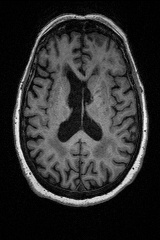

AD


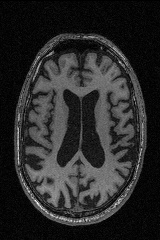

AD


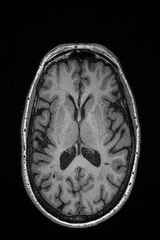

AD


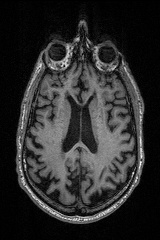

EMCI


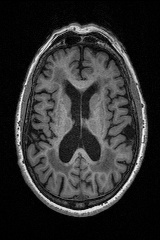

CN


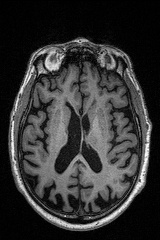

AD


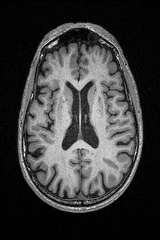

CN


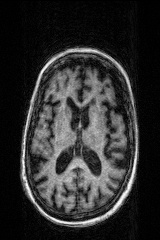

CN


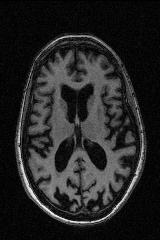

AD


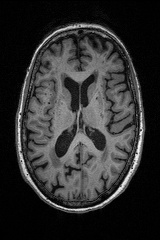

CN


In [21]:
def read_and_prep_images(img_paths, img_height=image_h, img_width=image_w):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    return preprocess_input(img_array)

random.shuffle(img_locations)
imgs = read_and_prep_images(img_locations)
predictions = model.predict_classes(imgs)
classes = dict((v,k) for k,v in train_generator.class_indices.items())

for img, prediction in zip(img_locations, predictions):
    display(Image(img))
    print(classes[prediction])